## Cancer Taxol Treatment Model

The goal of the notebook is to study practical identifiability of **Cancer Taxol Treatment Model** with *CICOBase*. Identifiability of this model was analyzed in [Marisa C.Eisenberg, Harsh V.Jain. A confidence building exercise in data and identifiability](https://www.sciencedirect.com/science/article/pii/S0022519317303454). We have translated Marisa's Matlab model from [cancer-chemo-identifiability repo](https://github.com/marisae/cancer-chemo-identifiability) to [Julia language](https://julialang.org/). 
The model is defined by the following system of differential equations:

In [1]:
using DiffEqBase, OrdinaryDiffEq, Plots, NLopt, CICOBase, DataFrames, Distributions
import Statistics: mean

# https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_de.m
function ode_func(du, u, p, t, drug)
    let (a0, ka, r0, d0, kd) = (p[1], p[2], p[3], p[4], p[5])

        K   = 10.515*100
        V0  = 1.3907*K
        lam = 9.5722

        theta = 10.

        # Values taken from 
        aRP  = 20.     # per day from Kim_PrlifQuies

        Ncel = u[1] + u[2] + u[3]
        Lfac = ((K-Ncel)^theta)/((V0^theta) + ((K-Ncel)^theta))

        arstexp = 3.
        adthexp = 4.

        arst = a0*(drug^arstexp)/(ka^arstexp + (drug^arstexp))
        adth = d0*(drug^adthexp)/(kd^adthexp + (drug^adthexp))
        arcv = r0

        # The differntial equations
        du[1] = -lam*u[1] + aRP*u[2]*Lfac - arst*u[1] + arcv*u[3]
        du[2] = 2*lam*u[1] - aRP*u[2]*Lfac
        du[3] = arst*u[1] - adth*u[3] - arcv*u[3]
    end
end;

Experimental datasets are also provided in [cancer-chemo-identifiability repo](https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_fit.m#L56-L105) for four drug doses (5, 10, 40, 100)

In [2]:
# https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_fit.m

# Data from Terzis et al. Brit J Cancer 1997;75:1744.
# From Bowman et al. Glia 1999;27:22, glioma cell volume is 0.916
# picoliters, 1 mm^3 = 1e6 pl or ~1.091 million cells

times = [0., 3., 6., 9., 12., 15.]   # days

dose = [5., 10., 40., 100.];    # dose in ng/ml

# Control data
Cell = [0.009, 0.050, 0.120, 0.189, 0.230, 0.260]*1091.0   # thousands of cells
Cerr = [0.006, 0.012, 0.010, 0.011, 0.011, 0.011]*1091.0   # thousands of cells

# 0.005 ug/ml Taxol
Cell005 = [0.009, 0.047, 0.089, 0.149, 0.198, 0.219]*1091.0   # thousands of cells
Cerr005 = [0.006, 0.013, 0.010, 0.011, 0.013, 0.010]*1091.0   # thousands of cells

# 0.010 ug/ml Taxol
Cell010 = [0.009, 0.043, 0.077, 0.093, 0.109, 0.128]*1091.0   # thousands of cells
Cerr010 = [0.006, 0.012, 0.013, 0.012, 0.014, 0.012]*1091.0   # thousands of cells

# 0.040 ug/ml Taxol
Cell040 = [0.009, 0.025, 0.047, 0.054, 0.076, 0.085]*1091.0   # thousands of cells
Cerr040 = [0.005, 0.010, 0.010, 0.011, 0.010, 0.010]*1091.0   # thousands of cells

# 0.100 ug/ml Taxol
Cell100 = [0.009, 0.025, 0.026, 0.028, 0.029, 0.031]*1091.0   # thousands of cells
Cerr100 = [0.006, 0.010, 0.009, 0.008, 0.011, 0.011]*1091.0   # thousands of cells

C005 = mean(Cell005)
C010 = mean(Cell010)
C040 = mean(Cell040)
C100 = mean(Cell100)

data = [Cell005/C005, Cell010/C010, Cell040/C040, Cell100/C100]
datamean = [C005, C010, C040, C100];

To visualize numerical simulations vs experimental data we can solve the ODE system and plot the results. Let's do it for  *dose=5*.   

In [3]:
# solver algorithm and tolerances
solver_opts = Dict(
    :alg => Rosenbrock23(),
    :reltol => 1e-3,
    :abstol => 1e-6
)

# initial values and parameters
# https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_soln.m#L3-L6
# https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_fit.m#L4

#P0 = 7.2700
#R0 = 2.5490

u0 = [7.2700, 2.5490, 0.]
p0 = [8.3170, 8.0959, 0.0582, 1.3307, 119.1363]

tspan = (0.,15.)

prob = ODEProblem((du,u,p,t)->ode_func(du,u,p,t,5.0), u0, tspan, p0)
sol = solve(
    prob, 
    solver_opts[:alg], 
    reltol=solver_opts[:reltol],
    abstol=solver_opts[:abstol],
    saveat=times
);

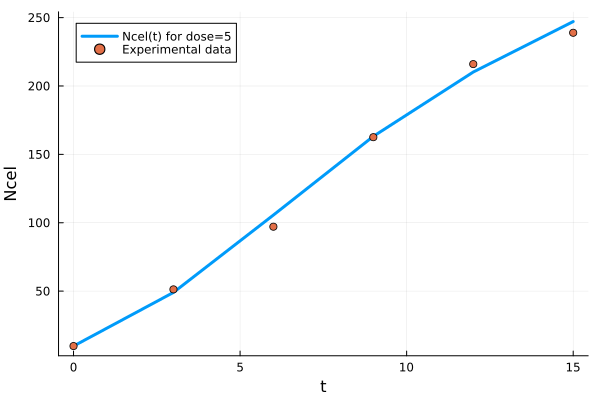

In [4]:
plot(sol.t, (sol[1,:]+sol[2,:]+sol[3,:]), xlabel = "t", ylabel = "Ncel", label="Ncel(t) for dose=5", line=3);
scatter!(times, Cell005, label = "Experimental data")

We need to define the objective function to run confidence intervals estimation. We use OLS fit as it was proposed in the original code:
$$ \Lambda = \sum_{i=1}^n \left( y(t_i) - data_i \right)^2 $$

Where
$n$ - number of observations (experimental data time points),
$data_i$ - experimental data,
$y(t_i)$ - numerical solution 

In [5]:
# https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_fit.m#L92
# https://www.mathworks.com/help/optim/ug/lsqcurvefit.html
function lsq_func(
    p;
    ode_func=ode_func,
    dose=dose,
    data=data,
    datamean=datamean,
    times=times,
    solver_opts=solver_opts
)
    loss = 0.
    
    for (i,d) in enumerate(dose)
       prob = ODEProblem((du,u,p,t)->ode_func(du,u,p,t,d), u0, tspan, p)
       sol = solve(prob, 
                   solver_opts[:alg], 
                   reltol=solver_opts[:reltol],
                   abstol=solver_opts[:abstol],
                   saveat=times)
        
       sim = (sol[1,:] + sol[2,:] + sol[3,:])/datamean[i]
       loss += sum((sim-data[i]).^2)
    end
    return loss
end;

We are ready to compute Confidence Intervals for *a0, ka, r0, d0, kd* with *CICOBase*

In [6]:
# threshold is chosen according to
# https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_fit.m#L40-L41
sigmasq = (mean([(Cerr005/C005); (Cerr010/C010); (Cerr040/C040); (Cerr100/C100)]))^2
threshold = sigmasq*cquantile(Chisq(5), 0.05)

α = lsq_func(p0) + threshold

intervals = Vector{ParamInterval}(undef,length(p0))
for i in eachindex(p0)
    
    # upper and lower scan bounds
    # https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_fit.m#L56-L105
    #lb = (1 - 0.05*14)*p0[i]
    #ub = (1 + 0.05*60)*p0[i]
    #theta_bounds = fill((1e-4,1e4),5)
    
    intervals[i] = get_interval(
        p0,
        i,
        lsq_func,
        :CICO_ONE_PASS,
        loss_crit = α,
        scan_bounds = (1e-3,1e3),
        scale = fill(:log,length(p0))
    )
    println(intervals[i]) 
end

left CP counter: 2    Time: 0:00:00 ( 0.25  s/it)
left CP counter: 286    Time: 0:00:00 ( 3.40 ms/it)
right CP counter: 171    Time: 0:00:00 ( 0.59 ms/it)
right CP counter: 338    Time: 0:00:00 ( 0.60 ms/it)
right CP counter: 503    Time: 0:00:00 ( 0.62 ms/it)
right CP counter: 602    Time: 0:00:00 ( 0.62 ms/it)


ParamInterval(ParamIntervalInput([8.317, 8.0959, 0.0582, 1.3307, 119.1363], 1, Main.lsq_func, :CICO_ONE_PASS, Dict{Symbol, Any}(:loss_crit => 0.9969368096327396, :scan_bounds => (0.001, 1000.0), :scale => [:log, :log, :log, :log, :log])), 0.5543989297852309, :CICO_ONE_PASS, (EndPoint(6.759329214244876, ProfilePoint[ProfilePoint(6.759329214244876, 0.9924943595466817, [6.759329214244876, 8.256344456490467, 1.9817511071795298e-10, 1.6586007246551167, 94.95892750454199], :FTOL_REACHED, nothing)], :BORDER_FOUND_BY_SCAN_TOL, :left, 286, 6.759329214244876), EndPoint(17.302679462368186, ProfilePoint[ProfilePoint(17.302679462368186, 0.9956708518516835, [17.302679462368186, 8.33131589398121, 0.34985139501527907, 15.628248415205716, 303.01625115751506], :FTOL_REACHED, nothing)], :BORDER_FOUND_BY_SCAN_TOL, :right, 602, 17.329102930750473)))


left CP counter: 172    Time: 0:00:00 ( 0.58 ms/it)
left CP counter: 343    Time: 0:00:00 ( 0.66 ms/it)
left CP counter: 512    Time: 0:00:00 ( 0.64 ms/it)
left CP counter: 523    Time: 0:00:00 ( 0.64 ms/it)
right CP counter: 164    Time: 0:00:00 ( 0.61 ms/it)
right CP counter: 339    Time: 0:00:00 ( 0.60 ms/it)
right CP counter: 350    Time: 0:00:00 ( 0.60 ms/it)


ParamInterval(ParamIntervalInput([8.317, 8.0959, 0.0582, 1.3307, 119.1363], 2, Main.lsq_func, :CICO_ONE_PASS, Dict{Symbol, Any}(:loss_crit => 0.9969368096327396, :scan_bounds => (0.001, 1000.0), :scale => [:log, :log, :log, :log, :log])), 0.5543989297852309, :CICO_ONE_PASS, (EndPoint(4.988704525570046, ProfilePoint[ProfilePoint(4.988704525570046, 0.9966367142978716, [8.575190186313096, 4.988704525570046, 0.18469854265473112, 1.032753052136969, 62.862908547911346], :FTOL_REACHED, nothing)], :BORDER_FOUND_BY_SCAN_TOL, :left, 523, 4.988704525570046), EndPoint(10.733968805768779, ProfilePoint[ProfilePoint(10.733968805768779, 0.99627443719079, [8.259835675742929, 10.733968805768779, 0.019831967244602757, 1.482003580289652, 143.5011672405034], :FTOL_REACHED, nothing)], :BORDER_FOUND_BY_SCAN_TOL, :right, 350, 10.733968805768779)))


right CP counter: 176    Time: 0:00:00 ( 0.58 ms/it)
right CP counter: 348    Time: 0:00:00 ( 0.61 ms/it)
right CP counter: 524    Time: 0:00:00 ( 0.60 ms/it)
right CP counter: 697    Time: 0:00:00 ( 0.61 ms/it)
right CP counter: 797    Time: 0:00:00 ( 0.62 ms/it)


ParamInterval(ParamIntervalInput([8.317, 8.0959, 0.0582, 1.3307, 119.1363], 3, Main.lsq_func, :CICO_ONE_PASS, Dict{Symbol, Any}(:loss_crit => 0.9969368096327396, :scan_bounds => (0.001, 1000.0), :scale => [:log, :log, :log, :log, :log])), 0.5543989297852309, :CICO_ONE_PASS, (EndPoint(nothing, ProfilePoint[], :SCAN_BOUND_REACHED, :left, 49, 0.0008153063791662839), EndPoint(0.4045462742487371, ProfilePoint[ProfilePoint(0.4045462742487371, 0.9968787940950203, [15.0959425352963, 6.987935478768365, 0.4045462742487371, 0.3410256688974108, 58.85802452482185], :FTOL_REACHED, nothing)], :BORDER_FOUND_BY_SCAN_TOL, :right, 797, 0.4045462742487371)))


left CP counter: 151    Time: 0:00:00 ( 0.67 ms/it)
left CP counter: 314    Time: 0:00:00 ( 0.65 ms/it)
left CP counter: 473    Time: 0:00:00 ( 0.65 ms/it)
left CP counter: 602    Time: 0:00:00 ( 0.66 ms/it)
right CP counter: 115    Time: 0:00:00 ( 0.88 ms/it)
right CP counter: 170    Time: 0:00:00 ( 0.81 ms/it)


ParamInterval(ParamIntervalInput([8.317, 8.0959, 0.0582, 1.3307, 119.1363], 4, Main.lsq_func, :CICO_ONE_PASS, Dict{Symbol, Any}(:loss_crit => 0.9969368096327396, :scan_bounds => (0.001, 1000.0), :scale => [:log, :log, :log, :log, :log])), 0.5543989297852309, :CICO_ONE_PASS, (EndPoint(0.18703851425547172, ProfilePoint[ProfilePoint(0.18703851425547172, 0.9970091474606448, [10.01843604602707, 8.981783216538687, 0.07194353484460049, 0.18703851425547172, 70.77251071685085], :FTOL_REACHED, nothing)], :BORDER_FOUND_BY_SCAN_TOL, :left, 602, 0.1873545682587843), EndPoint(nothing, ProfilePoint[], :SCAN_BOUND_REACHED, :right, 170, 2.056974662333836e16)))


left CP counter: 126    Time: 0:00:00 ( 0.79 ms/it)
left CP counter: 265    Time: 0:00:00 ( 0.76 ms/it)
left CP counter: 419    Time: 0:00:00 ( 0.73 ms/it)
left CP counter: 571    Time: 0:00:00 ( 0.72 ms/it)
left CP counter: 720    Time: 0:00:00 ( 0.73 ms/it)
left CP counter: 797    Time: 0:00:00 ( 0.81 ms/it)
right CP counter: 103    Time: 0:00:00 ( 0.97 ms/it)
right CP counter: 214    Time: 0:00:00 ( 0.96 ms/it)
right CP counter: 223    Time: 0:00:00 ( 0.99 ms/it)


ParamInterval(ParamIntervalInput([8.317, 8.0959, 0.0582, 1.3307, 119.1363], 5, Main.lsq_func, :CICO_ONE_PASS, Dict{Symbol, Any}(:loss_crit => 0.9969368096327396, :scan_bounds => (0.001, 1000.0), :scale => [:log, :log, :log, :log, :log])), 0.5543989297852309, :CICO_ONE_PASS, (EndPoint(50.515927620015816, ProfilePoint[ProfilePoint(50.515927620015816, 0.9974642637398783, [8.831456506782727, 6.8582115047390255, 0.14304346162063303, 0.5358898046182273, 50.515927620015816], :FTOL_REACHED, nothing)], :BORDER_FOUND_BY_SCAN_TOL, :left, 797, 50.56847398398075), EndPoint(nothing, ProfilePoint[], :SCAN_BOUND_REACHED, :right, 223, 1897.5539243235398)))


In [7]:
ENV["COLUMNS"]=120
cico_res = DataFrame(
    Parameters = [:a0, :ka, :r0, :d0, :kd], 
    StatusLower = [k.result[1].status for k in intervals],
    StatusUpper = [k.result[2].status for k in intervals],
    CILower = [k.result[1].value for k in intervals],
    CIUpper = [k.result[2].value for k in intervals],
    LFLowerCalls = [k.result[1].counter for k in intervals],
    LFUpperCalls = [k.result[2].counter for k in intervals],
    NominalStartValues = p0
)
cico_res

Row,Parameters,StatusLower,StatusUpper,CILower,CIUpper,LFLowerCalls,LFUpperCalls,NominalStartValues
,Symbol,Symbol,Symbol,Union…,Union…,Int64,Int64,Float64
1,a0,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,6.75933,17.3027,286,602,8.317
2,ka,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,4.9887,10.734,523,350,8.0959
3,r0,SCAN_BOUND_REACHED,BORDER_FOUND_BY_SCAN_TOL,,0.404546,49,797,0.0582
4,d0,BORDER_FOUND_BY_SCAN_TOL,SCAN_BOUND_REACHED,0.187039,,602,170,1.3307
5,kd,BORDER_FOUND_BY_SCAN_TOL,SCAN_BOUND_REACHED,50.5159,,797,223,119.136


### CICOBase vs Original Implementation Comparison

Endpoints esimated in the [original Matlab code](https://github.com/marisae/cancer-chemo-identifiability). Lower and upper CI endpoints for original Matlab implementation are given as intervals because stepwise PL approach doesn’t estimate endpoints with any preset tolerance but marks two points before and after parameters profile intersects the threshold.

In [8]:
ENV["COLUMNS"]=120
orig_res = DataFrame(
    Parameters = [:a0, :ka, :r0, :d0, :kd], 
    StatusLower = ["identified", "identified", "not udentified", "identified", "identified"],
    StatusUpper = ["identified", "identified", "identified", "not udentified", "not udentified"],
    CILower = [(7.90115,8.317), (4.85754, 5.26233499), :NULL, (0.13307,0.199605), (47.654519, 53.611335)],
    CIUpper = [(17.04985, 17.4657), (10.52467, 10.929465), (0.36375, 0.36666), :NULL, :NULL],
    LFLowerCalls = [285, 685, 1510, 1605, 930],
    LFUpperCalls = [1715, 670, 7475, ">20000", 12260],
    NominalStartValues = p0
)
orig_res

Row,Parameters,StatusLower,StatusUpper,CILower,CIUpper,LFLowerCalls,LFUpperCalls,NominalStartValues
,Symbol,String,String,Any,Any,Int64,Any,Float64
1,a0,identified,identified,"(7.90115, 8.317)","(17.0498, 17.4657)",285,1715,8.317
2,ka,identified,identified,"(4.85754, 5.26233)","(10.5247, 10.9295)",685,670,8.0959
3,r0,not udentified,identified,NULL,"(0.36375, 0.36666)",1510,7475,0.0582
4,d0,identified,not udentified,"(0.13307, 0.199605)",NULL,1605,>20000,1.3307
5,kd,identified,not udentified,"(47.6545, 53.6113)",NULL,930,12260,119.136


In general CI endpoints found with *CICOBase* fit into intervals estimated in the original implementation. Two values (a0_lower, r0_upper) are outside of the estimated intervals. The original intervals can be verified by additional fitting

According to the original results a0 lower CI endpoint is between (7.90115, 8.317) values. Hence the Profile Likelihood function should intersect the threashold between these points. Let's check it

In [9]:
fitter_opts = Dict(
    :alg => :LN_NELDERMEAD,
    :lb => [1e-9, 1e-9, 1e-9, 1e-9, 1e-9],
    :ub => [1e9, 1e9, 1e9, 1e9, 1e9]
)

a0_lower_loss = Vector{Float64}(undef, 2)

for (i,a0) in enumerate((7.90115, 8.317))
    
    fitter_opts[:lb][1] = a0
    fitter_opts[:ub][1] = a0
    opt = Opt(fitter_opts[:alg], 5)
    lower_bounds!(opt, fitter_opts[:lb])
    upper_bounds!(opt, fitter_opts[:ub])
    opt.min_objective = (p,grad) -> lsq_func(p)
    (loss,p,ret) = NLopt.optimize(opt, p0)

    a0_lower_loss[i] = loss-α
end

println((7.90115, a0_lower_loss[1]))
println((8.317, a0_lower_loss[2]))

(7.90115, -0.4574330942918253)
(8.317, -0.455567035564163)


a0 profile is below the threashold between (7.90115, 8.317) which means profiling can lead to inaccurate CI endpoints estimation. The same can be checked for original r0 upper endpoint estimation:

In [10]:
fitter_opts = Dict(
    :alg => :LN_NELDERMEAD,
    :lb => [1e-9, 1e-9, 1e-9, 1e-9, 1e-9],
    :ub => [1e9, 1e9, 1e9, 1e9, 1e9]
)

r0_upper_loss = Vector{Float64}(undef, 2)

for (i,r0) in enumerate((0.36375, 0.36666))
    
    fitter_opts[:lb][3] = r0
    fitter_opts[:ub][3] = r0
    opt = Opt(fitter_opts[:alg], 5)
    lower_bounds!(opt, fitter_opts[:lb])
    upper_bounds!(opt, fitter_opts[:ub])
    opt.min_objective = (p,grad) -> lsq_func(p)
    (loss,p,ret) = NLopt.optimize(opt, p0)

    r0_upper_loss[i] = loss-α
end

println((0.36375, r0_upper_loss[1]))
println((0.36666, r0_upper_loss[2]))

(0.36375, -0.03679984726322372)
(0.36666, -0.0340795912489561)


### Results

1. Confidence intervals estimated with *CICOBase* correspond with those reported in [Marisa C.Eisenberg, Harsh V.Jain. A confidence building exercise in data and identifiability](https://www.sciencedirect.com/science/article/pii/S0022519317303454)
2. Stepwise optimization-based algorithm used in the original Matlab implementation may lead to inaccurate CI endpoints estimates.
3. *a0, ka* are practically identifiable parameters
4. *d0, kd* are practically unindentifiable (CI have infinite upper bounds)
5. *r0* can be considered as identifiable parameter if zero is the natural lower bound for it. However *r0* profile has only one intersection with the threashold confidence level